In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import numpy as np
import os, time
import random
import matplotlib.pyplot as plt
random.seed(0)


readvdnames = lambda x: open(x).read().rstrip().split('\n')

################################# DEFINE DATASET #################################
class TinySegData(Dataset):
    def __init__(self, db_root="TinySeg", img_size=256, phase='train'):
        classes = ['person', 'bird', 'car', 'cat', 'plane', ]
        seg_ids = [1, 2, 3, 4, 5]

        templ_image = db_root + "/JPEGImages/{}.jpg"
        templ_mask = db_root + "/Annotations/{}.png"

        ids = readvdnames(db_root + "/ImageSets/" + phase + ".txt")

        # build training and testing dbs
        samples = []
        for i in ids:
            samples.append([templ_image.format(i), templ_mask.format(i)])
        self.samples = samples
        self.phase = phase
        self.db_root = db_root
        self.img_size = img_size

        self.color_transform = torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)

        if not self.phase == 'train':
            print ("resize and augmentation will not be applied...")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.phase == 'train':
            return self.get_train_item(idx)
        else:
            return self.get_train_item(idx)

    def get_train_item(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample[0])

        if random.randint(0, 1) > 0:
            image = self.color_transform(image)
        image = np.asarray(image)[..., ::-1]     # to BGR
        seg_gt = (np.asarray(Image.open(sample[1]).convert('P'))).astype(np.uint8)

        image = image.astype(np.float32)
        image = image / 127.5 - 1        # -1~1

        if random.randint(0, 1) > 0:
            image = image[:, ::-1, :]       # HWC
            seg_gt = seg_gt[:, ::-1]

        # random crop to 256x256
        height, width = image.shape[0], image.shape[1]
        if height == width:
            miny, maxy = 0, 256
            minx, maxx = 0, 256
        elif height > width:
            miny = np.random.randint(0, height-256)
            maxy = miny+256
            minx = 0
            maxx = 256
        else:
            miny = 0
            maxy = 256
            minx = np.random.randint(0, width-256)
            maxx = minx+256
        image = image[miny:maxy, minx:maxx, :].copy()
        seg_gt = seg_gt[miny:maxy, minx:maxx].copy()

        if self.img_size != 256:
            new_size = (self.img_size, self.img_size)
            image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)
            seg_gt = cv2.resize(seg_gt, new_size, interpolation=cv2.INTER_NEAREST)

        image = np.transpose(image, (2, 0, 1))      # To CHW

        # cv2.imwrite("test.png", np.concatenate([(image[0]+1)*127.5, seg_gt*255], axis=0))
        return image, seg_gt, sample

    def get_test_item(self, idx):
        sample = self.samples[idx]
        image = cv2.imread(sample[0])
        seg_gt = (np.asarray(Image.open(sample[1]).convert('P'))).astype(np.uint8)

        image = image.astype(np.float32)
        image = image / 127.5 - 1        # -1~1
        image = np.transpose(image, (2, 0, 1))

        # cv2.imwrite("test.png", np.concatenate([(image[0]+1)*127.5, seg_gt*255], axis=0))
        return image, seg_gt, sample

################################# FUNCTIONS #################################
def get_confusion_matrix(gt_label, pred_label, class_num):
        """
        Calcute the confusion matrix by given label and pred
        :param gt_label: the ground truth label
        :param pred_label: the pred label
        :param class_num: the number of class
        :return: the confusion matrix
        """
        index = (gt_label * class_num + pred_label).astype('int32')

        label_count = np.bincount(index)
        confusion_matrix = np.zeros((class_num, class_num))

        for i_label in range(class_num):
            for i_pred_label in range(class_num):
                cur_index = i_label * class_num + i_pred_label
                if cur_index < len(label_count):
                    confusion_matrix[i_label, i_pred_label] = label_count[cur_index]

        return confusion_matrix

def get_confusion_matrix_for_3d(gt_label, pred_label, class_num):
    confusion_matrix = np.zeros((class_num, class_num))

    for sub_gt_label, sub_pred_label in zip(gt_label, pred_label):
        sub_gt_label = sub_gt_label[sub_gt_label != 255]
        sub_pred_label = sub_pred_label[sub_pred_label != 255]
        cm = get_confusion_matrix(sub_gt_label, sub_pred_label, class_num)
        confusion_matrix += cm
    return confusion_matrix



In [2]:
def draw(epoches,Loss_list,Accuracy_list):
    x1 = range(0, epoches)
    x2 = range(0, epoches)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()

In [3]:
dataset = TinySegData(img_size=128, phase='train')
test = TinySegData(img_size=128,phase='val')
resnetdataset = TinySegData(img_size=224, phase='train')
resnettest = TinySegData(img_size=224,phase='val')

resize and augmentation will not be applied...
resize and augmentation will not be applied...


In [4]:
train_loader = DataLoader(resnetdataset, batch_size=64)
test_loader = DataLoader(resnettest,batch_size=64)


In [5]:


def bcdcode(label_arrays, num_classes=6):  
    # 将输入转换为一个 PyTorch 张量，确保是长整型以避免后续问题  
    labels = torch.tensor(label_arrays, dtype=torch.long)  
    
    # 创建一个形状为 (样本数, num_classes) 的全零张量  
    binary_encodings = torch.zeros((labels.shape[0], num_classes), dtype=torch.int)  

    # 对于每个样本，使用 `torch.arange` 生成行索引，然后将各个标签位置设为 1  
    for i in range(labels.shape[0]):  
        binary_encodings[i, labels[i]] = 1  
    
    # 将第一列（索引为0）的值设为0  
    binary_encodings[:, 0] = 0  
    
    return binary_encodings  




In [12]:
len(train_loader)

188

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # 定义网络层  
        self.conv1 = nn.Conv2d(3, 18, kernel_size=21)  
        self.conv2 = nn.Conv2d(18, 48, kernel_size=21)  
        self.fc1 = nn.Linear(48 * 17 * 17, 360)  
        self.fc2 = nn.Linear(360, 84)  
        self.fc3 = nn.Linear(84, 6)  

    def forward(self, x):  
        # 定义前向传播过程  
        x = nn.functional.relu(self.conv1(x))  
        x = nn.functional.max_pool2d(x, 2)  
        x = nn.functional.relu(self.conv2(x))  
        x = nn.functional.max_pool2d(x, 2)  
        x = x.view(-1, 48 * 17 * 17)  # flatten  
        x = nn.functional.relu(self.fc1(x))  
        x = nn.functional.relu(self.fc2(x))  
        x = self.fc3(x)
        return x  
    


In [8]:
class vgg16(nn.Module):
    def __init__(self,):
        super(vgg16,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.GELU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#这里使用两个3X3的卷积核代替5X5


            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.MaxPool2d(kernel_size=2, stride=2),  


            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(1024, 2048, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(2048, 4096, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(4096, 4096, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.Conv2d(4096, 4096, kernel_size=3, padding=1),  
            nn.GELU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )


        self.classifier = nn.Sequential(
            nn.Linear(4096 * 1 * 1, 4096),  
            nn.GELU(),  
            nn.Dropout(),  
            nn.Linear(4096, 4096),  
            nn.GELU(),  
            nn.Dropout(),  #防过拟合
            nn.Linear(4096, 6),  
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


In [ ]:
example = LeNet().to(device)

lr = 0.01
epoches = 60
criterion = nn.BCEWithLogitsLoss().to(device)
loss_list = []
accuracy_list = []
loss_list1 = []
accuracy_list1 = []
optimizer = torch.optim.Adam(example.parameters(),lr=lr)

for epoch in range(epoches):
    train_loss = 0
    train_acc = 0
    train_tp = 0
    train_fp = 0
    train_fn = 0
    train_tn = 0
    label_sum = 0
    for img,label,_ in train_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = example(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        train_tp += tp  
        train_fp += fp  
        train_tn += tn  
        train_fn += fn  
        label_sum +=label.sum().item()  


    total_samples = train_tp + train_fp + train_tn + train_fn  
    accuracy = (train_tp + train_tn) / total_samples
    accuracy1 = train_tp/label_sum
    loss_list.append(train_loss/len(train_loader))
    accuracy_list.append(accuracy)
    accuracy_list1.append(accuracy1)
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f},trainacc:{:.6f}'.format(epoch+1, train_loss/len(train_loader), accuracy,accuracy1))

epoch: 1, Train Loss: 6.496219, Train Acc: 0.830389,trainacc:0.421259
epoch: 2, Train Loss: 0.343880, Train Acc: 0.853222,trainacc:0.437021
epoch: 3, Train Loss: 0.344289, Train Acc: 0.853333,trainacc:0.429737
epoch: 4, Train Loss: 0.344496, Train Acc: 0.852806,trainacc:0.430854
epoch: 5, Train Loss: 0.344984, Train Acc: 0.852694,trainacc:0.433004
epoch: 6, Train Loss: 0.344963, Train Acc: 0.852278,trainacc:0.436972
epoch: 7, Train Loss: 0.345432, Train Acc: 0.851667,trainacc:0.427609
epoch: 8, Train Loss: 0.345338, Train Acc: 0.852139,trainacc:0.426353
epoch: 9, Train Loss: 0.345659, Train Acc: 0.851472,trainacc:0.419552
epoch: 10, Train Loss: 0.345524, Train Acc: 0.852250,trainacc:0.424276
epoch: 11, Train Loss: 0.345151, Train Acc: 0.852167,trainacc:0.421424
epoch: 12, Train Loss: 0.344758, Train Acc: 0.852417,trainacc:0.432157
epoch: 13, Train Loss: 0.345998, Train Acc: 0.851361,trainacc:0.426713
epoch: 14, Train Loss: 0.347586, Train Acc: 0.851528,trainacc:0.429691
epoch: 15, Trai

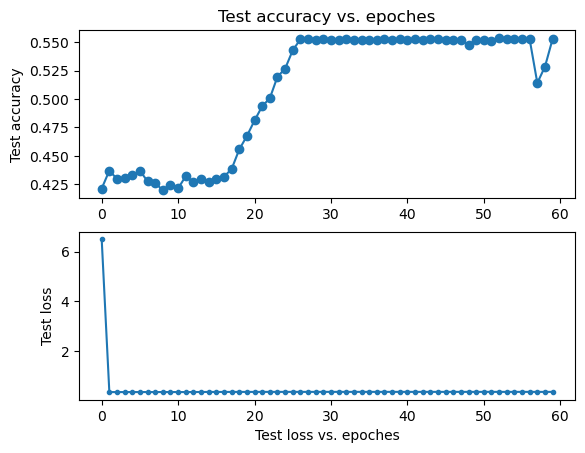

In [15]:
draw(60,loss_list,accuracy_list1)

In [17]:
test_loss = 0
test_acc = 0
test_tp = 0
test_fp = 0
test_fn = 0
test_tn = 0
label_sum = 0
for img,label,_ in test_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = example(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        test_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        test_tp += tp  
        test_fp += fp  
        test_tn += tn  
        test_fn += fn  
        label_sum +=label.sum().item()  


total_samples = test_tp + test_fp + test_tn + test_fn  
accuracy = (test_tp + test_tn) / total_samples
accuracy1 = test_tp/label_sum
print(accuracy1)

0.6122754491017964


In [14]:
example = vgg16().to(device)

lr = 0.0001
epoches = 40
criterion = nn.BCEWithLogitsLoss().to(device)
loss_list = []
accuracy_list = []
loss_list1 = []
accuracy_list1 = []
optimizer = torch.optim.Adam(example.parameters(),lr=lr)

for epoch in range(20):

    train_loss = 0
    train_acc = 0
    train_tp = 0
    train_fp = 0
    train_fn = 0
    train_tn = 0
    label_sum = 0
    for img,label,_ in train_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = example(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        train_tp += tp  
        train_fp += fp  
        train_tn += tn  
        train_fn += fn  
        label_sum +=label.sum().item()  

    total_samples = train_tp + train_fp + train_tn + train_fn  
    accuracy = (train_tp + train_tn) / total_samples
    accuracy1 = train_tp/label_sum
    loss_list.append(train_loss/len(train_loader))
    accuracy_list.append(accuracy)
    accuracy_list1.append(accuracy1)
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f},trainacc:{:.6f}'.format(epoch+1, train_loss/len(train_loader), accuracy,accuracy1))


epoch: 1, Train Loss: 0.369906, Train Acc: 0.848639,trainacc:0.367132
epoch: 2, Train Loss: 0.346355, Train Acc: 0.851250,trainacc:0.396425
epoch: 3, Train Loss: 0.346398, Train Acc: 0.851694,trainacc:0.405706
epoch: 4, Train Loss: 0.345591, Train Acc: 0.851000,trainacc:0.414252
epoch: 5, Train Loss: 0.348069, Train Acc: 0.850806,trainacc:0.393512
epoch: 6, Train Loss: 0.345580, Train Acc: 0.851833,trainacc:0.416797
epoch: 7, Train Loss: 203.797728, Train Acc: 0.804528,trainacc:0.440577
epoch: 8, Train Loss: 0.640471, Train Acc: 0.846139,trainacc:0.529062
epoch: 9, Train Loss: 0.588751, Train Acc: 0.851361,trainacc:0.548448
epoch: 10, Train Loss: 0.555523, Train Acc: 0.851611,trainacc:0.550275
epoch: 11, Train Loss: 0.528982, Train Acc: 0.851639,trainacc:0.551011
epoch: 12, Train Loss: 0.506346, Train Acc: 0.852222,trainacc:0.553085
epoch: 13, Train Loss: 0.486494, Train Acc: 0.851917,trainacc:0.552421
epoch: 14, Train Loss: 0.468538, Train Acc: 0.852222,trainacc:0.552673
epoch: 15, Tr

In [18]:
test_loss = 0
test_acc = 0
test_tp = 0
test_fp = 0
test_fn = 0
test_tn = 0
label_sum = 0
for img,label,_ in test_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = example(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        test_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        test_tp += tp  
        test_fp += fp  
        test_tn += tn  
        test_fn += fn  
        label_sum +=label.sum().item()  


total_samples = test_tp + test_fp + test_tn + test_fn  
accuracy = (test_tp + test_tn) / total_samples
accuracy1 = test_tp/label_sum
print(accuracy1)

0.6083086053412463


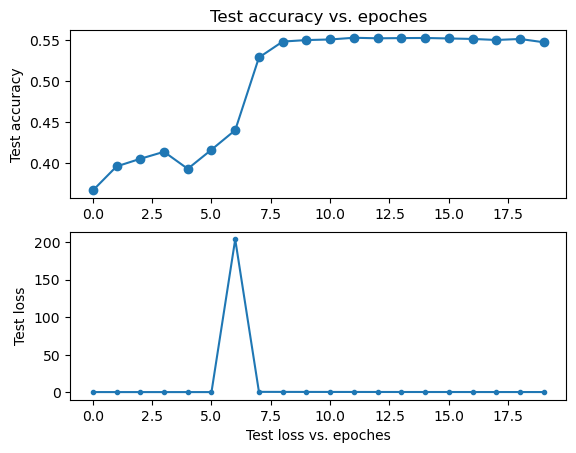

In [16]:
draw(20,loss_list,accuracy_list1)

In [11]:
resnetexample = torchvision.models.resnet18(pretrained=False)
resnetexample.fc = nn.Linear(resnetexample.fc.in_features,6)
resnetexample = resnetexample.to(device)

d:\study\pytorch\anaconda\envs\test-cv2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\study\pytorch\anaconda\envs\test-cv2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
lr = 0.0001
epoches = 40
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnetexample.parameters(),lr=lr)
loss_list = []
accuracy_list = []
loss_list1 = []
accuracy_list1 = []

for epoch in range(40):

    train_loss = 0
    train_acc = 0
    train_tp = 0
    train_fp = 0
    train_fn = 0
    train_tn = 0
    label_sum = 0
    for img,label,_ in train_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = resnetexample(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        train_tp += tp  
        train_fp += fp  
        train_tn += tn  
        train_fn += fn  
        label_sum +=label.sum().item()  

    total_samples = train_tp + train_fp + train_tn + train_fn  
    accuracy = (train_tp + train_tn) / total_samples
    accuracy1 = train_tp/label_sum
    loss_list.append(train_loss/len(train_loader))
    accuracy_list.append(accuracy)
    accuracy_list1.append(accuracy1)
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f},trainacc:{:.6f}'.format(epoch+1, train_loss/len(train_loader), accuracy,accuracy1))


epoch: 1, Train Loss: 1.224367, Train Acc: 0.712056,trainacc:0.876115
epoch: 2, Train Loss: 1.034373, Train Acc: 0.696944,trainacc:0.940881
epoch: 3, Train Loss: 0.982212, Train Acc: 0.693833,trainacc:0.953612
epoch: 4, Train Loss: 0.942944, Train Acc: 0.694111,trainacc:0.956195
epoch: 5, Train Loss: 0.900608, Train Acc: 0.701500,trainacc:0.963445
epoch: 6, Train Loss: 0.873345, Train Acc: 0.703167,trainacc:0.964632
epoch: 7, Train Loss: 0.844809, Train Acc: 0.709361,trainacc:0.967398
epoch: 8, Train Loss: 0.829750, Train Acc: 0.712694,trainacc:0.968227
epoch: 9, Train Loss: 0.795652, Train Acc: 0.719833,trainacc:0.971393
epoch: 10, Train Loss: 0.771592, Train Acc: 0.723056,trainacc:0.971904
epoch: 11, Train Loss: 0.762835, Train Acc: 0.726389,trainacc:0.971348
epoch: 12, Train Loss: 0.733719, Train Acc: 0.734250,trainacc:0.976646
epoch: 13, Train Loss: 0.707161, Train Acc: 0.741500,trainacc:0.975094
epoch: 14, Train Loss: 0.694814, Train Acc: 0.744000,trainacc:0.976668
epoch: 15, Trai

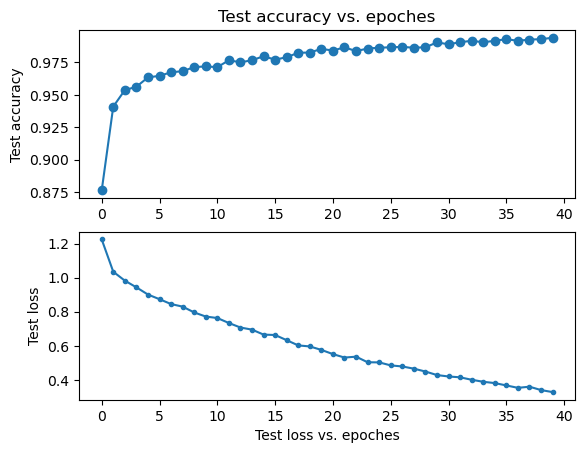

In [13]:
draw(40,loss_list,accuracy_list1)

In [14]:
test_loss = 0
test_acc = 0
test_tp = 0
test_fp = 0
test_fn = 0
test_tn = 0
label_sum = 0
for img,label,_ in test_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = resnetexample(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        test_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        test_tp += tp  
        test_fp += fp  
        test_tn += tn  
        test_fn += fn  
        label_sum +=label.sum().item()  


total_samples = test_tp + test_fp + test_tn + test_fn  
accuracy = (test_tp + test_tn) / total_samples
accuracy1 = test_tp/label_sum
print(accuracy1)

0.9267563527653214
